<a href="https://colab.research.google.com/github/Muun-Muun/collision_avoidance_for_satellite/blob/main/optimal_ca_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_continuous_lyapunov

plt.style.use('seaborn-v0_8-whitegrid')

<ipython-input-48-dc88e456092f>:71: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


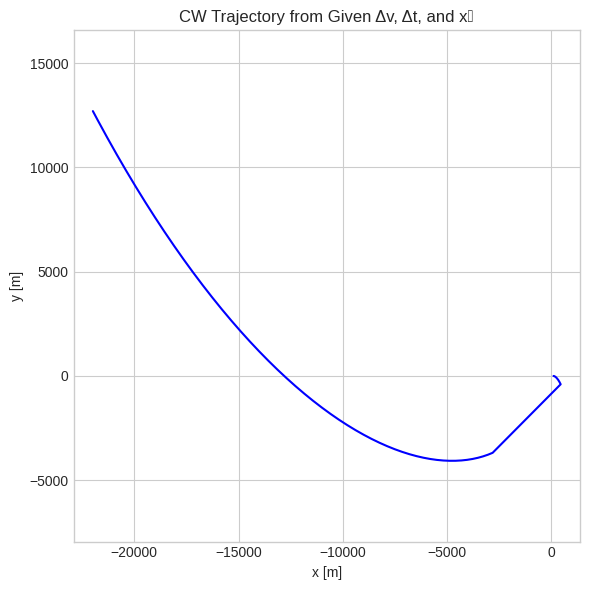

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 클래스 불러오기 (앞서 작성한 것들이 있다고 가정)
# from cw_calculator import CWCalculator
# from cw_plotter import CWPlotter

# 1. 클래스 인스턴스 생성
n = 0.001027  # mean motion (rad/s)
cw_calc = CWCalculator(n)
cw_plot = CWPlotter()

# 2. 초기 상태 및 사용자 정의 임펄스/시간
x0 = np.array([100, 0, 0, 0, 0.01, 0])  # [x, y, z, vx, vy, vz]
delta_vs = np.array([
    [0.0, 0.0, 0.0],
    [0.0, -0.01, 0.0],
    [0.0, 0.0, 0.01]
])
dt_list = [600, 1000, 1200]  # seconds

# 3. 궤도 시뮬레이션 (임펄시브)
trajectory, t_arr = cw_calc.propagate(x0, control=True, t_impulses=dt_list, delta_vs=delta_vs)

# 4. 충돌확률 시각화용 설정 (예시 공분산)
r_rel = trajectory[-1, :2]
C_rel = np.array([[5**2, 2], [2, 10**2]])  # km^2 → m^2
C_rel = C_rel * 1e6  # convert to m^2

# 5. 시각화
fig, ax = plt.subplots(figsize=(7, 7))

# 궤적
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', label='Trajectory')
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', label='Start')
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='End')

# Δv 벡터
for i in range(len(dt_list)):
    idx = int((i + 1) * len(t_arr) / (len(dt_list) + 1))  # 구간 중간 위치 추정
    dv = delta_vs[i][:2]
    pos = trajectory[idx, :2]
    cw_plot.plot_dv_arrow(ax, pos, dv, scale=500, color='orange')

# 공분산 타원 + Pc 등고선
cw_plot.draw_pc_contour(r_rel, C_rel, ax, range=(15000, 15000), HBR=1.0, density=8, alpha=0.4)

# 꾸미기
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Optimized Impulsive CW Trajectory with Pc Contour')
ax.grid(True)
ax.axis('equal')
ax.legend()
plt.tight_layout()
plt.show()


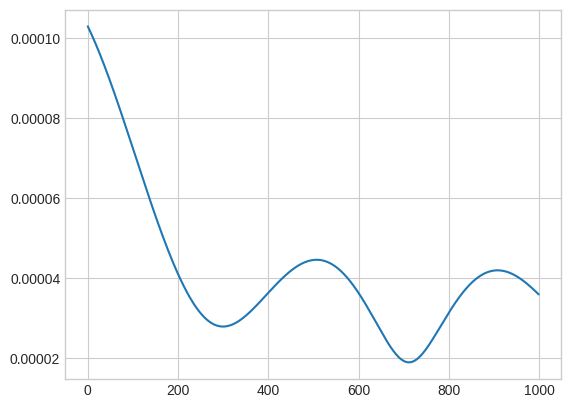

In [39]:
plt.plot(np.linalg.norm(U_opt, axis=1))

In [4]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 12.1 MB/s eta 0:00:00


<ipython-input-1-a2b078dc7a1b>:29: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contour(X, Z, Pc, levels=levels, cmap='rainbow', norm=LogNorm(), alpha=alpha)


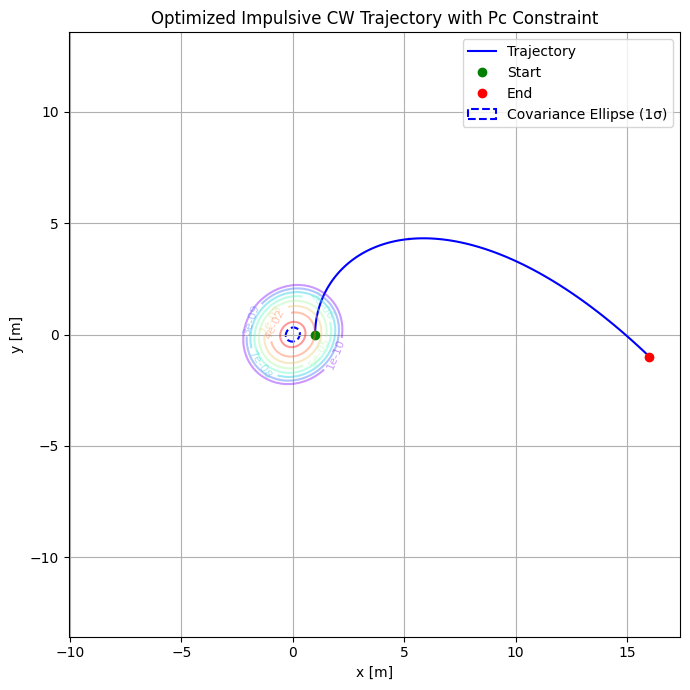

In [20]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import expm
import matplotlib.pyplot as plt

# CW 시스템 설정
n = 0.001027
x0 = np.array([1, 0, 0, 0, 0.01, 0])
K = 1
HBR = 0.1
Pc_max = 1e-4
C_rel = np.array([[0.1, 0.01], [0.01, 0.1]])

calc = CWCalculator(n)
plotter = CWPlotter()
A = calc.A
B = calc.B
C_inv = np.linalg.inv(C_rel)
C_det_sqrt = np.sqrt(np.linalg.det(C_rel))

# 목적함수 정의
def objective(x):
    delta_vs = x[:3*K].reshape((3, K))
    return np.sum(np.linalg.norm(delta_vs, axis=0)**2)

# 제약 조건 함수 정의
def constraint(x):
    delta_vs = x[:3*K].reshape((3, K))
    delta_ts = x[3*K:]
    xk = x0.copy()
    for k in range(K):
        Phi_k = expm(A * delta_ts[k])
        Gamma_k = calc.compute_gamma(delta_ts[k])
        xk = Phi_k @ xk + Gamma_k @ delta_vs[:, k]
    constraints = list(xk)
    r_final = xk[:2]
    d2 = r_final.T @ C_inv @ r_final
    pre_factor = (HBR**2) / (2 * np.pi * C_det_sqrt)
    Pc = pre_factor * np.exp(-0.5 * d2)
    constraints.append(Pc - Pc_max)
    return np.array(constraints)

# 초기 guess, 경계 설정
guess = np.concatenate([np.zeros(3*K), np.ones(K) * 1200])
bounds = [(-0.05, 0.05)] * (3*K) + [(100, 1800)] * K
cons = {'type': 'eq', 'fun': constraint}

# 최적화 실행
res = minimize(objective, guess, method='SLSQP', bounds=bounds, constraints=cons)
x_opt = res.x
delta_vs_opt = x_opt[:3*K].reshape((3, K))
delta_ts_opt = x_opt[3*K:]

delta_vs_opt = x_opt[:3*K].reshape((3, K)) * 0


# 시뮬레이션 및 시각화
# traj_nocontrol, _ = calc.propagate(x0, control=False)
trajectory, _ = calc.propagate(x0, control=True, t_impulses=delta_ts_opt, delta_vs=delta_vs_opt.T)
r_rel_final = trajectory[-1, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', label='Trajectory')
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', label='Start')
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='End')

for i in range(K):
    idx = int((i + 1) * len(trajectory) / (K + 1))
    pos = trajectory[idx, :2]
    dv = delta_vs_opt[:2, i]
    plotter.plot_dv_arrow(ax, pos, dv, scale=500, color='orange')

plotter.draw_pc_contour(r_rel_final, C_rel, ax, range=(10, 10), HBR=1.0, density=8, alpha=0.4)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Optimized Impulsive CW Trajectory with Pc Constraint')
ax.grid(True)
ax.axis('equal')
ax.legend()
plt.tight_layout()
plt.show()

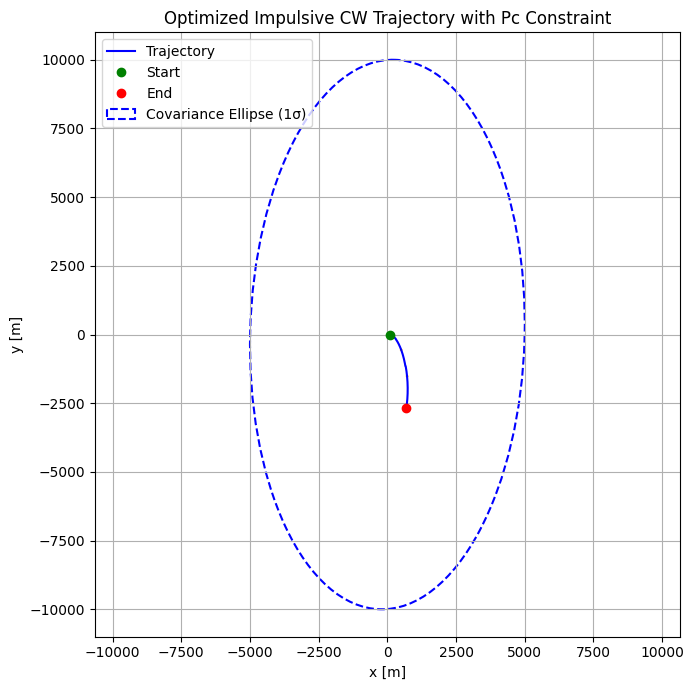

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', label='Trajectory')
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', label='Start')
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='End')

for i in range(K):
    idx = int((i + 1) * len(trajectory) / (K + 1))
    pos = trajectory[idx, :2]
    dv = delta_vs_opt[:2, i]
    plotter.plot_dv_arrow(ax, pos, dv, scale=500, color='orange')

plotter.draw_pc_contour(r_rel_final, C_rel, ax, range=(10, 10), HBR=1.0, density=8, alpha=0.4)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Optimized Impulsive CW Trajectory with Pc Constraint')
ax.grid(True)
ax.axis('equal')
ax.legend()
plt.tight_layout()
plt.show()

# Class


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from numpy.linalg import inv, eigh, norm
import numpy as np


class CWPlotter:
    def __init__(self):
        pass

    def draw_pc_contour(self, r_rel, C_rel, ax, range=(10, 10), HBR=1.0, density=10, alpha=0.5):
        C_inv = inv(C_rel)
        eigvals, eigvecs = eigh(C_rel)
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigvals)
        sigma_x, sigma_y = np.sqrt(C_rel[0, 0]), np.sqrt(C_rel[1, 1])

        x_vals = np.linspace(-range[0], range[0], 400)
        z_vals = np.linspace(-range[1], range[1], 400)
        X, Z = np.meshgrid(x_vals, z_vals)

        d2_grid = np.einsum('...i,ij,...j->...', np.dstack((X, Z)), C_inv, np.dstack((X, Z)))
        pre_factor = HBR ** 2 / (2 * sigma_x * sigma_y)
        Pc = pre_factor * np.exp(-0.5 * d2_grid)

        levels = np.logspace(-10, -0, num=density)
        contour = ax.contour(X, Z, Pc, levels=levels, cmap='rainbow', norm=LogNorm(), alpha=alpha)
        ax.clabel(contour, inline=True, fmt=lambda v: f"{v:.0e}", fontsize=8)

        ellipse = Ellipse((0, 0), width=width, height=height, angle=angle,
                          edgecolor='blue', linestyle='--', lw=1.5,
                          facecolor='none', label='Covariance Ellipse (1σ)')
        ax.add_patch(ellipse)

    def plot_covariance_ellipse(self, cov, ax, n_std=1.0, edgecolor='blue', **kwargs):
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        width, height = 2 * n_std * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                          edgecolor=edgecolor, facecolor='none', **kwargs)
        ax.add_patch(ellipse)

    def plot_dv_arrow(self, ax, position, delta_v, scale=1.0, color='black', label=None):
        x0, y0 = position[0], position[1]
        dx, dy = delta_v[0] * scale, delta_v[1] * scale
        ax.quiver(x0, y0, dx, dy, angles='xy', scale_units='xy', scale=1,
                  color=color, width=0.005)

        if label:
            legend_handle = Line2D([0], [0], color=color, lw=2, marker='>',
                                   markersize=8, label=label)
            return legend_handle
        else:
            return None


In [2]:
# 계산 클래스: CW 동역학 및 최적화 관련
import numpy as np
from scipy.linalg import expm, eig
from numpy.linalg import norm


class CWCalculator:
    def __init__(self, n):
        self.n = n
        self.A = np.array([
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
            [3 * n ** 2, 0, 0, 0, 2 * n, 0],
            [0, 0, 0, -2 * n, 0, 0],
            [0, 0, -n ** 2, 0, 0, 0]
        ])
        self.B = np.vstack([np.zeros((3, 3)), np.eye(3)])

    def compute_gamma(self, dt, steps=100):
        tau = np.linspace(0, dt, steps)
        integrand_sum = np.zeros((self.A.shape[0], self.B.shape[1]))
        for t in dt - tau:
            integrand_sum += expm(self.A * t) @ self.B
        return (dt / steps) * integrand_sum

    def cw_closed_form(self, t, x0):
        x0_, y0_, z0_, vx0_, vy0_, vz0_ = x0
        nt = self.n * t
        x = (4 - 3 * np.cos(nt)) * x0_ + np.sin(nt) / self.n * vx0_ + 2 * (1 - np.cos(nt)) / self.n * vy0_
        y = 6 * (np.sin(nt) - nt) * x0_ + y0_ - 2 * (1 - np.cos(nt)) / self.n * vx0_ + (4 * np.sin(nt) - 3 * nt) / self.n * vy0_
        z = z0_ * np.cos(nt) + vz0_ / self.n * np.sin(nt)
        return np.vstack((x, y, z)).T

    def propagate(self, x0, t_span=None, control=False, t_impulses=None, delta_vs=None, steps_per_segment=100):
        xk = x0.copy()
        trajectory = []
        times = []

        if not control:
            assert t_span is not None, "t_span must be provided if control=False"
            t = np.linspace(0, t_span, steps_per_segment)
            traj = self.cw_closed_form(t, xk)
            return traj, t
        else:
            assert t_impulses is not None and delta_vs is not None
            t_start = 0.0
            for i in range(len(t_impulses)):
                dt = t_impulses[i]
                t_segment = np.linspace(0, dt, steps_per_segment)
                traj_segment = self.cw_closed_form(t_segment, xk)
                trajectory.append(traj_segment)
                times.append(t_segment + t_start)
                t_start += dt
                Phi_k = expm(self.A * dt)
                Gamma_k = self.compute_gamma(dt)
                xk = Phi_k @ xk + Gamma_k @ delta_vs[i]
            return np.vstack(trajectory), np.hstack(times)

    def get_max_impact_delta_v(self, A, delta_v_max):
        ATA = A.T @ A
        eigvals, eigvecs = eig(ATA)
        v_opt = eigvecs[:, np.argmax(eigvals)]
        return v_opt / norm(v_opt) * delta_v_max

    def get_min_pc_delta_v(self, cov, delta_v_max):
        eigvals, eigvecs = eig(cov)
        v_dir = eigvecs[:, np.argmin(eigvals)]
        v_dir = v_dir / norm(v_dir) * delta_v_max
        return np.array([v_dir[0], v_dir[1], 0.0])
